# Embedding Model Fine-tuning

Finally, we get to fine-tune some models!

After covering the basics of embedding models, generating synthetic queries, and mining positive and negative examples, we move on to the last part of this workshop: fine-tuning an open-weight embedding model on our own data.

As there are already plenty of great fine-tuning tutorials, we will keep the additional comments in this notebook brief and refer to these two excellent introductory resources:
- [Training and Finetuning Embedding Models with Sentence Transformers v3](https://huggingface.co/blog/train-sentence-transformers)
- [Fine-tune Embedding models for Retrieval Augmented Generation (RAG)](https://www.philschmid.de/fine-tune-embedding-model-for-rag)

In this notebook, we will cover the following parts:
1. **Data preparation**: Loading the data we prepared in notebooks 3 and 4 to create two training sets — one with and another without mined examples. We'll also prepare an evaluation set.
2. **Baseline evaluation**: Loading a pre-trained embedding model and measuring its performance on our evaluation set using the metrics introduced in notebook 1.
3. **Fine-tuning**: Fine-tuning three models using different combinations of original passages, mined positives and negatives, and random in-batch negatives.
4. **Results**: Comparing the performance of our three fine-tuned models to understand which approach works best for our specific domain.

## Setup

> ***Important:*** *If you want to evaluate or train the models in this notebook, make sure to have a GPU runtime enabled. Click on `Runtime` > `Change runtime type` > Select `T4 GPU` and Save.*

> *Also, to make sure there are no older sessions running, click on `Runtime` > `Manage sessions` > `Terminate other sessions`*

For training, we will use [Sentence Transformers](https://www.sbert.net/) and PyTorch. For data preprocessing we use pandas and Hugging Face [datasets](https://huggingface.co/docs/datasets/index).

In [ ]:
# Update sentence transformers and install HF datasets
!pip install -qU sentence-transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Download datasets
%%capture
!wget "https://drive.google.com/uc?export=download&id=1r6Ac113CFN7geatE_Lvm6XR9S4fQwCOn" -O ./training_data.csv
!wget "https://drive.google.com/uc?export=download&id=1LXnkFupSdhTvYFc6tXEJc_0j3_fdQKHv" -O ./eval_queries.csv
!wget "https://drive.google.com/uc?export=download&id=1NO42oUkoq5fcyXFo70qN1sJMqntC5fN7" -O ./aiact_corpus.csv

In [ ]:
import ast
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments
)
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers.losses import (
    MultipleNegativesRankingLoss, CachedMultipleNegativesRankingLoss
)
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.util import cos_sim

## 1. Data preparation

### 1.1 Load datasets

First, we load the **synthetic training queries** we prepared in notebooks `03_query_gen_solution.ipynb` and `04_negative_mining.ipynb`

In [ ]:
df_train = pd.read_csv(
    "training_data.csv", converters={"negatives": ast.literal_eval}
)[["query", "psg_id", "positive_doc", "negatives"]]
df_train.head(3)

,query,psg_id,positive_doc,negatives
0,How does the EU's AI Act ensure patient safety...,0,74,"[5, 192, 436, 563, 438]"
1,In a scenario where a new AI system is develop...,0,0,"[26, 9, 506, 229, 82]"
2,How does the EU's AI Act balance promoting inn...,1,7,"[9, 5, 8, 92, 74]"


Next, we load the entire **AI Act corpus** chunked into passages up to 512 tokens

In [ ]:
df_corpus = pd.read_csv("aiact_corpus.csv")
df_corpus.head(3)

,psg_id,passage,source
0,0,Preamble\n\n(1)The purpose of this Regulation ...,preamble
1,1,Preamble\n\n(2)This Regulation should be appli...,preamble
2,2,Preamble\n\n(3)AI systems can be easily deploy...,preamble


In [ ]:
print(f"Number of passages: {len(df_corpus)}")

Number of passages: 787


Note that most real-world corpora are much larger, often spanning even millions of documents or passages. We selected a small corpus deliberately so we can run fine-tuning and evaluation in this workshop within manageable timeframes.

***How do we evaluate our model?***

To measure the impact of our fine-tuning efforts, we need an **evaluation set**. We've prepared this in advance using a different and more complex synthetic data generation process than what we covered in previous notebooks. In real-world applications, you would ideally use manually written examples or at least have human experts review and improve synthetic data to ensure evaluation quality.

In [ ]:
df_eval = pd.read_csv("eval_queries.csv")
df_eval.head(3)

,orig_psg_id,psg_id,query_id,query,passage
0,7,7,0,How will a single set of AI rules across the E...,Preamble\n\n(8)A Union legal framework laying ...
1,7,2,0,How will a single set of AI rules across the E...,Preamble\n\n(3)AI systems can be easily deploy...
2,7,154,0,How will a single set of AI rules across the E...,Preamble\n\n(139)The objectives of the AI regu...


To prevent data leakage, we exclude all training queries that were generated from passages that were also used for generating evaluation queries. This ensures we don't artificially inflate our evaluation metrics.

In [ ]:
df_train = df_train[~df_train.psg_id.isin(df_eval.orig_psg_id.unique())].reset_index(drop=True).copy()
len(df_train)

1368

We are left with 1368 training examples, which is very small for fine-tuning embedding models.

### 1.2 Adding Prefixes

Embedding models often expect specific formatting of inputs based on how they were trained. The [E5 small](https://huggingface.co/intfloat/e5-small-v2) model we'll be using was trained with distinct prefixes to differentiate between symmetric (e.g. sentence similarity) and asymmetric (e.g. retrieval) embedding tasks.

Following the model's expected input format for retrieval tasks, we'll add `"query: "` to all queries and `"passage: "` to all passages.

In [ ]:
df_train["query"] = "query: " + df_train["query"]
df_eval["query"] = "query: " + df_eval["query"]
df_corpus["passage"] = "passage: " + df_corpus["passage"]

In [ ]:
df_train.head(3)

,query,psg_id,positive_doc,negatives
0,query: How does the EU's AI Act ensure patient...,0,74,"[5, 192, 436, 563, 438]"
1,query: In a scenario where a new AI system is ...,0,0,"[26, 9, 506, 229, 82]"
2,query: How does the EU's AI Act balance promot...,1,7,"[9, 5, 8, 92, 74]"


### 1.3 Prepare Evaluation Data

To measure our model's retrieval performance, we'll use the [InformationRetrievalEvaluator](https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#informationretrievalevaluator) from the Sentence Transformers library. This evaluator requires data in a specific format consisting of three dictionaries:

1. `queries`: Contains evaluation queries, mapping query IDs to query texts
2. `corpus`: Contains the full document corpus, mapping passage IDs to passage texts
3. `relevant_docs`: Defines our ground truth, mapping each query ID in `queries` to a list of relevant passage IDs from `corpus`

In [ ]:
queries = df_eval.set_index("query_id")["query"].to_dict()
corpus = df_corpus.set_index("psg_id")["passage"].to_dict()
relevant_docs = df_eval.groupby("query_id").psg_id.apply(list).to_dict()
len(queries), len(corpus), len(relevant_docs)

(99, 787, 99)

We have 99 evaluation queries in total.

### 1.4 Prepare Training Data

We will prepare two datasets:
- `df_basic`: Uses the original passage from query generation as positive passage without mined hard negatives
- `df_mined`: Uses the mined positive and negative passages from notebook `04_negative_mining.ipynb`

The data structure of the training sets is given by the specific loss function used for fine-tuning. For this workshop, we'll use [MultipleNegativesRankingLoss](https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss), which requires data structured as:

```
Dataset({
    features: ['anchor', 'positive', 'negative1', 'negative2', 'negative3', ...],
    num_rows: 1368
})
```

Note that the order of columns is important, not their names. You can provide as many hard negatives as you like. If no hard negatives are provided, only random in-batch negatives will be used.

> *For an overview of alternative loss functions, see the this [loss overview](https://www.sbert.net/docs/sentence_transformer/loss_overview.html)*

In [ ]:
# Select relevant columns
df_basic = df_train[["query", "psg_id"]].copy()
df_mined = df_train[["query", "positive_doc", "negatives"]].copy()

In [ ]:
# Get passage text from passage ID
df_basic["positive"] = df_basic.psg_id.map(corpus)
df_mined["positive"] = df_mined.positive_doc.map(corpus)

In [ ]:
# Create negative columns for df_mined
for i in range(5):
    df_mined[f'negative{i+1}'] = df_mined['negatives'].apply(lambda x: corpus[x[i]] if len(x) > i else None)

In [ ]:
# Drop additional columns
df_basic.drop(columns=["psg_id"], inplace=True)
df_mined.drop(columns=["negatives", "positive_doc"], inplace=True)

In [ ]:
df_basic.head(3)

,query,positive
0,query: How does the EU's AI Act ensure patient...,passage: Preamble\n\n(1)The purpose of this Re...
1,query: In a scenario where a new AI system is ...,passage: Preamble\n\n(1)The purpose of this Re...
2,query: How does the EU's AI Act balance promot...,passage: Preamble\n\n(2)This Regulation should...


In [ ]:
df_mined.head(3)

,query,positive,negative1,negative2,negative3,negative4,negative5
0,query: How does the EU's AI Act ensure patient...,passage: Preamble\n\n(64)To mitigate the risks...,passage: Preamble\n\n(6)Given the major impact...,passage: Preamble\n\n(173)In order to ensure t...,passage: Chapter III - HIGH-RISK AI SYSTEMS\n\...,passage: Chapter VIII - EU DATABASE FOR HIGH-R...,passage: Chapter III - HIGH-RISK AI SYSTEMS\n\...
1,query: In a scenario where a new AI system is ...,passage: Preamble\n\n(1)The purpose of this Re...,"passage: Preamble\n\n(24)If, and insofar as, A...",passage: Preamble\n\nplaced on various operato...,passage: Chapter VI - MEASURES IN SUPPORT OF I...,passage: Chapter II - PROHIBITED AI PRACTICES\...,passage: Preamble\n\n(70)In order to protect t...
2,query: How does the EU's AI Act balance promot...,passage: Preamble\n\n(8)A Union legal framewor...,passage: Preamble\n\nplaced on various operato...,passage: Preamble\n\n(6)Given the major impact...,passage: Preamble\n\n(9)Harmonised rules appli...,passage: Preamble\n\n(80)As signatories to the...,passage: Preamble\n\n(64)To mitigate the risks...


In [ ]:
df_basic.positive.nunique(), df_mined.positive.nunique()

(716, 593)

While `df_basic` nearly covers the entire corpus, `df_mined` is missing a lot more passages as a result of positive mining. This means that a side effect of our mining process is that less relevant passages no longer appear in the training data at all. In case that would be a problem, the omitted passages could be included again to increase coverage.

Finally, we convert our datasets from pandas to Hugging Face Datasets

In [ ]:
ds_basic = Dataset.from_pandas(df_basic)
ds_mined = Dataset.from_pandas(df_mined)

In [ ]:
ds_basic

Dataset({
    features: ['query', 'positive'],
    num_rows: 1368
})

In [ ]:
ds_mined

Dataset({
    features: ['query', 'positive', 'negative1', 'negative2', 'negative3', 'negative4', 'negative5'],
    num_rows: 1368
})

We now have two training datasets with 1368 queries each, and both are formatted in the correct way.

## 2. Baseline Evaluation

Before fine-tuning our own models, we'll first evaluate the performance of the pretrained model to establish a baseline. For this notebook, we'll use [E5 small](https://huggingface.co/intfloat/e5-small-v2) as our base model. Its compact size allows us to complete the fine-tuning process on a free Colab T4 GPU within a reasonable timeframe.

In [ ]:
model_name = "intfloat/e5-small-v2"  # Hugging Face model name

# Load the model and move it to GPU
model = SentenceTransformer(
    model_name, device="cuda" if torch.cuda.is_available() else "cpu"
)

Next, we define an `InformationRetrievalEvaluator` to assess our model's performance. For each query in our evaluation set, the evaluator will search through the entire AI Act corpus. It will use the provided model to embed both queries and passages, then rank the passages based on cosine similarity. Finally, it will compute the set of retrieval metrics we covered in notebook 1, allowing us to quantify performance.

In [ ]:
evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    score_functions={"cosine": cos_sim}
)

In [ ]:
baseline_results = evaluator(model)

In [ ]:
baseline_results

{'cosine_accuracy@1': 0.5656565656565656,
 'cosine_accuracy@3': 0.7575757575757576,
 'cosine_accuracy@5': 0.8282828282828283,
 'cosine_accuracy@10': 0.9292929292929293,
 'cosine_precision@1': 0.5656565656565656,
 'cosine_precision@3': 0.44444444444444453,
 'cosine_precision@5': 0.35353535353535354,
 'cosine_precision@10': 0.2515151515151515,
 'cosine_recall@1': 0.17627631391586732,
 'cosine_recall@3': 0.3201908626549774,
 'cosine_recall@5': 0.4130842664335488,
 'cosine_recall@10': 0.54756109564722,
 'cosine_ndcg@10': 0.5214716196977872,
 'cosine_mrr@10': 0.6813371813371814,
 'cosine_map@100': 0.4556241201363954}

We observe that `accuracy@10` is already above 90%, but other metrics like `recall@10` and `NDCG@10` are much lower. This suggests that while at least one relevant passage appears in the top-10 results for most queries, *we fail to retrieve all relevant passages*. Thus, the overall ranking quality leaves significant room for improvement.

## 3. Fine-tuning

We will fine-tune three models with different approaches:

1. Using `MultipleNegativesRankingLoss` with original passages as positives and random in-batch negatives
2. Using `CachedMultipleNegativesRankingLoss` with mined positives and negatives, plus random in-batch negatives
3. Using `CustomMultipleNegativesRankingLoss` with mined positives and negatives, but no in-batch negatives

### 3.1 Original Positives and In-Batch Negatives

For our first model, we'll disregard the positive and negative mining process from notebook `04_negative_mining.ipynb` entirely. Instead, we'll simply use the original passages that were used for query generation as positives.

When not provided with any explicit negatives, `MultipleNegativesRankingLoss` will only use *random in-batch negatives* during training. This means that for each query, the passages from all other queries in the same batch serve as its set of negatives.

In [ ]:
loss = MultipleNegativesRankingLoss(model)

Next, we'll define training arguments with reasonable defaults. While these settings will work well for our workshop purposes, for optimal performance in real-world applications, you would typically perform a hyper-parameter sweep. For more details on all available training arguments, refer to the [Sentence Transformers documentation](https://www.sbert.net/docs/package_reference/sentence_transformer/training_args.html)

In [ ]:
train_args = SentenceTransformerTrainingArguments(
    output_dir="e5-small-ft-random",            # output directory
    num_train_epochs=3,                         # number of epochs
    per_device_train_batch_size=32,             # train batch size
    per_device_eval_batch_size=32,              # evaluation batch size
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=5e-6,                         # learning rate, 5e-6 is a good value
    lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="cosine_ndcg@10",     # select the main metric to track
    report_to="none"                            # disable logging
)

*Disclaimer: a batch size of 32 is considered very small when training with in-batch negatives. For a real training run, you should consider training on multiple GPUs with batch sizes of several thousand examples.*

We now define the `SentenceTransformerTrainer` which combines model, training arguments, training data, loss function and optionally an evaluator to be run during training.

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=train_args,
    train_dataset=ds_basic,
    loss=loss,
    evaluator=evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Start the training run

In [ ]:
trainer.train()  # takes ca 2.5 minutes to complete

Epoch,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
1,1.156600,No log,0.626263,0.808081,0.878788,0.939394,0.626263,0.430976,0.357576,0.242424,0.204571,0.360363,0.454114,0.553714,0.543101,0.731578,0.473268
2,0.416700,No log,0.656566,0.848485,0.909091,1.000000,0.656566,0.464646,0.371717,0.257576,0.229047,0.389628,0.475687,0.606530,0.588231,0.767184,0.507771
3,0.325100,No log,0.666667,0.878788,0.939394,0.989899,0.666667,0.484848,0.385859,0.263636,0.232173,0.403180,0.496647,0.619148,0.602793,0.780415,0.520723


TrainOutput(global_step=129, training_loss=0.8765363896539969, metrics={'train_runtime': 152.0821, 'train_samples_per_second': 26.985, 'train_steps_per_second': 0.848, 'total_flos': 0.0, 'train_loss': 0.8765363896539969, 'epoch': 3.0})

Run evaluation with the fine-tuned model

In [ ]:
results_random = evaluator(model)

We define a helper function to compare two sets of results

In [ ]:
def compare_results(results_ft, results):
    # Define column widths for alignment
    metric_width = max(len(metric.split("_")[1]) for metric in results) + 2
    value_width = 10  # Enough space for values with 4 decimal places
    change_width = 12  # Enough space for percentage with sign

    # Create header and separator line
    header = f"{'Metric':<{metric_width}} {'Original':<{value_width}} {'Fine-tuned':<{value_width}} {'Change':<{change_width}}"
    separator = "-" * (metric_width + value_width + value_width + change_width)

    # Print header
    print(header)
    print(separator)

    # Generate and print a row for each metric
    for metric in results:
        metric_name = metric.split("_")[1]
        improvement = (results_ft[metric] - results[metric]) / results[metric] * 100
        sign = "+" if improvement >= 0 else ""

        # Format the change with the percentage sign right after the number
        change_str = f"{sign}{improvement:.2f}%"

        row = f"{metric_name:<{metric_width}} {results[metric]:<{value_width}.4f} {results_ft[metric]:<{value_width}.4f} {change_str:<{change_width}}"
        print(row)

In [ ]:
compare_results(results_random, baseline_results)

Metric         Original   Fine-tuned Change      
----------------------------------------------
accuracy@1     0.5657     0.6667     +17.86%     
accuracy@3     0.7576     0.8788     +16.00%     
accuracy@5     0.8283     0.9394     +13.41%     
accuracy@10    0.9293     0.9899     +6.52%      
precision@1    0.5657     0.6667     +17.86%     
precision@3    0.4444     0.4848     +9.09%      
precision@5    0.3535     0.3859     +9.14%      
precision@10   0.2515     0.2636     +4.82%      
recall@1       0.1763     0.2322     +31.71%     
recall@3       0.3202     0.4032     +25.92%     
recall@5       0.4131     0.4966     +20.23%     
recall@10      0.5476     0.6191     +13.07%     
ndcg@10        0.5215     0.6028     +15.59%     
mrr@10         0.6813     0.7804     +14.54%     
map@100        0.4556     0.5207     +14.29%     


We already observe a very decent improvement in key metrics. However, as we mentioned earlier, the original passages used for query generation may not always be the most relevant across the entire corpus. Moreover, the model may benefit from seeing more difficult cases than random negatives during training.

### 3.2 Mined Positives and Negatives + In-Batch Negatives

For our second model, we'll leverage the mined positives and negatives from notebook `04_negative_mining.ipynb`. This approach combines the 5 hard negative passages we carefully mined for each query with the random in-batch negatives that `MultipleNegativesRankingLoss` automatically adds during training.

To ensure we start with a fresh pre-trained model (rather than continuing from the model in section 3.1), we'll reload the base model.

In [ ]:
model = SentenceTransformer(
    model_name, device="cuda" if torch.cuda.is_available() else "cpu"
)

Since the free T4 GPU runs out of memory when using a batch size of 32 with 5 provided negatives per query, we'll use the memory-efficient [CachedMultipleNegativesRankingLoss](https://sbert.net/docs/package_reference/sentence_transformer/losses.html#cachedmultiplenegativesrankingloss) instead. This alternative implementation trades off some training speed to reduce memory requirements, allowing us to maintain the same batch size without exceeding our GPU's limits.

In [ ]:
loss = CachedMultipleNegativesRankingLoss(model, scale=40)

As we'll now train on both hard and in-batch negatives and there is no weight to adjust, we increase the loss function's scale parameter which makes harder cases have more effect during training.

All other settings are kept identical

In [ ]:
train_args = SentenceTransformerTrainingArguments(
    output_dir="e5-small-ft-mined",             # output directory
    num_train_epochs=3,                         # number of epochs
    per_device_train_batch_size=32,             # train batch size
    per_device_eval_batch_size=32,              # evaluation batch size
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=5e-6,                         # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="cosine_ndcg@10",     # select the main metric to track
    report_to="none"                            # disable logging
)

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=train_args,
    train_dataset=ds_mined,
    loss=loss,
    evaluator=evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
trainer.train()  # takes ca 13 minutes to complete

Epoch,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
1,1.432700,No log,0.676768,0.858586,0.919192,0.969697,0.676768,0.481481,0.375758,0.267677,0.225278,0.399115,0.483579,0.604856,0.592421,0.774299,0.519243
2,0.742300,No log,0.727273,0.929293,0.959596,0.989899,0.727273,0.521886,0.410101,0.281818,0.242209,0.431775,0.516223,0.635820,0.632586,0.819024,0.563429
3,0.738400,No log,0.717172,0.929293,0.959596,1.000000,0.717172,0.521886,0.412121,0.284848,0.236317,0.431017,0.522171,0.646839,0.638105,0.820539,0.566421


TrainOutput(global_step=129, training_loss=1.3379180893417477, metrics={'train_runtime': 795.4295, 'train_samples_per_second': 5.159, 'train_steps_per_second': 0.162, 'total_flos': 0.0, 'train_loss': 1.3379180893417477, 'epoch': 3.0})

In [ ]:
results_mined = evaluator(model)

In [ ]:
compare_results(results_mined, baseline_results)

Metric         Original   Fine-tuned Change      
----------------------------------------------
accuracy@1     0.5657     0.7172     +26.79%     
accuracy@3     0.7576     0.9293     +22.67%     
accuracy@5     0.8283     0.9596     +15.85%     
accuracy@10    0.9293     1.0000     +7.61%      
precision@1    0.5657     0.7172     +26.79%     
precision@3    0.4444     0.5219     +17.42%     
precision@5    0.3535     0.4121     +16.57%     
precision@10   0.2515     0.2848     +13.25%     
recall@1       0.1763     0.2363     +34.06%     
recall@3       0.3202     0.4310     +34.61%     
recall@5       0.4131     0.5222     +26.41%     
recall@10      0.5476     0.6468     +18.13%     
ndcg@10        0.5215     0.6381     +22.37%     
mrr@10         0.6813     0.8205     +20.43%     
map@100        0.4556     0.5664     +24.32%     


We observe even stronger improvements when using mined positives and hard negatives alongside in-batch negatives. All metrics show substantial gains, with `accuracy@10` reaching 100% and significant improvements in `recall` and `NDCG@10`.

### 3.3 Mined Positives and Negatives (No In-Batch Negatives)

For our third and final model, we want to evaluate the impact of our carefully mined negatives in isolation without the influence of random in-batch negatives. This approach reduces the risk of false negatives (passages that are actually relevant being treated as negative examples).

Since Sentence Transformers doesn't offer this option natively in `MultipleNegativesRankingLoss`, we'll implement a custom version in PyTorch that uses only our explicit negatives.

In [ ]:
from __future__ import annotations
from collections.abc import Iterable
from typing import Any
import torch
from torch import Tensor, nn
from sentence_transformers import util
from sentence_transformers.SentenceTransformer import SentenceTransformer

class CustomMultipleNegativesRankingLoss(nn.Module):
    def __init__(self, model: SentenceTransformer, scale: float = 20.0, similarity_fct = util.cos_sim) -> None:
        super().__init__()
        self.model = model
        self.scale = scale
        self.similarity_fct = similarity_fct
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, sentence_features: Iterable[dict[str, Tensor]], labels: Tensor) -> Tensor:
        # Get embeddings for all features
        embeddings = [self.model(sentence_feature)["sentence_embedding"] for sentence_feature in sentence_features]

        # Split embeddings into queries, positives, and multiple negatives
        queries = embeddings[0]     # Shape: (batch_size, embedding_dim)
        # Concatenate positive and negative embeddings
        candidates = torch.cat(embeddings[1:])   # Shape: (batch_size * num_candidates, embedding_dim)

        # Compute similarity scores between each query and all candidates
        scores = self.similarity_fct(queries, candidates) * self.scale  # Shape: (batch_size, batch_size * num_candidates)

        # Calculate indices for selecting the correct candidates for each query
        batch_size = queries.shape[0]
        num_candidates_total = candidates.shape[0]
        num_candidates_per_query = num_candidates_total // batch_size

        # Create indices corresponding to the start of candidates for each query item
        # [0, B, 2B, ..., (K-1)B] where K = num_candidates_per_query, B = batch_size
        candidate_start_indices = torch.arange(0, num_candidates_total, batch_size, device=scores.device)  # Shape: (K,)

        # Select the scores corresponding to the candidates for each query i:
        # scores[i, i + candidate_start_indices]
        # Example: query 0 -> scores[0, [0, B, 2B, ...]]
        #          query 1 -> scores[1, [1, 1+B, 1+2B, ...]]
        indices = torch.arange(batch_size, device=scores.device).unsqueeze(1) + candidate_start_indices.unsqueeze(0)
        # indices shape: (batch_size, num_candidates_per_query)

        # Gather the relevant scores using the calculated indices
        # Need to gather along dim=1
        selected_scores = torch.gather(scores, 1, indices) # Shape: (batch_size, num_candidates_per_query)

        # The positive candidate is always the first one (index 0) after concatenation and selection
        positive_indices = torch.zeros(batch_size, dtype=torch.long, device=scores.device)

        # Compute the CrossEntropyLoss using the selected scores
        computed_loss = self.cross_entropy_loss(selected_scores, positive_indices)

        return computed_loss

    def get_config_dict(self) -> dict[str, Any]:
        return {"scale": self.scale, "similarity_fct": self.similarity_fct.__name__}

Initialize model and loss function

In [ ]:
model = SentenceTransformer(
    model_name, device="cuda" if torch.cuda.is_available() else "cpu"
)

custom_loss = CustomMultipleNegativesRankingLoss(model)

We train with a smaller batch size to avoid out-of-memory errors

In [ ]:
train_args = SentenceTransformerTrainingArguments(
    output_dir="e5-small-ft-custom",            # output directory
    num_train_epochs=3,                         # number of epochs
    per_device_train_batch_size=8,              # train batch size
    per_device_eval_batch_size=8,               # evaluation batch size
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=5e-6,                         # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="cosine_ndcg@10",     # select the main metric to track
    report_to="none"                            # disable logging
)

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=train_args,
    train_dataset=ds_mined,
    loss=custom_loss,
    evaluator=evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
trainer.train()  # takes ca 12 minutes to complete

Epoch,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
1,0.335800,No log,0.747475,0.898990,0.959596,1.000000,0.747475,0.525253,0.414141,0.287879,0.241564,0.423602,0.514387,0.657389,0.644323,0.832167,0.567066
2,0.150900,No log,0.787879,0.919192,0.949495,0.989899,0.787879,0.528620,0.426263,0.297980,0.253264,0.420656,0.525126,0.670035,0.660718,0.855904,0.581948
3,0.151600,No log,0.797980,0.929293,0.949495,0.989899,0.797980,0.538721,0.422222,0.302020,0.258315,0.426717,0.522600,0.681579,0.670175,0.864141,0.586461


TrainOutput(global_step=513, training_loss=0.3913476474975285, metrics={'train_runtime': 693.0106, 'train_samples_per_second': 5.922, 'train_steps_per_second': 0.74, 'total_flos': 0.0, 'train_loss': 0.3913476474975285, 'epoch': 3.0})

In [ ]:
results_custom = evaluator(model)

In [ ]:
compare_results(results_custom, baseline_results)

Metric         Original   Fine-tuned Change      
----------------------------------------------
accuracy@1     0.5657     0.7980     +41.07%     
accuracy@3     0.7576     0.9293     +22.67%     
accuracy@5     0.8283     0.9495     +14.63%     
accuracy@10    0.9293     0.9899     +6.52%      
precision@1    0.5657     0.7980     +41.07%     
precision@3    0.4444     0.5387     +21.21%     
precision@5    0.3535     0.4222     +19.43%     
precision@10   0.2515     0.3020     +20.08%     
recall@1       0.1763     0.2583     +46.54%     
recall@3       0.3202     0.4267     +33.27%     
recall@5       0.4131     0.5226     +26.51%     
recall@10      0.5476     0.6816     +24.48%     
ndcg@10        0.5215     0.6702     +28.52%     
mrr@10         0.6813     0.8641     +26.83%     
map@100        0.4556     0.5865     +28.72%     


Our final model, using only carefully mined hard negatives without any in-batch negatives, delivers the strongest results yet. The focused approach yields substantial gains in our key ranking metrics, with `recall@10` improving by 24.5% and `NDCG@10` increasing by 28.5%.

## 4. Results

Finally, let's visualize and compare the results from all four approaches: the pre-trained baseline and our three fine-tuned models.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualize_metrics(results_list, model_names):
    """
    Visualize recall@3, recall@5, recall@10, and ndcg@10 metrics for multiple models.

    Parameters:
    -----------
    results_list : list of dict
        List of dictionaries containing metrics for each model
    model_names : list of str
        List of model names corresponding to each results dict
    """
    # Metrics to visualize
    metrics = ['recall@3', 'recall@5', 'recall@10', 'ndcg@10']

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Prepare data for Seaborn
    data = []
    for i, (result, model) in enumerate(zip(results_list, model_names)):
        for metric in metrics:
            data.append({
                'Model': model,
                'Metric': metric,
                'Score': result[f"cosine_{metric}"]
            })

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Create plot
    plt.figure(figsize=(12, 7))
    palette = sns.color_palette("husl", len(model_names))

    # Create the bar plot with Seaborn
    ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df, palette=palette)

    # Enhance the plot
    ax.set_title('Results Comparison', fontsize=16, fontweight='bold')
    ax.set_xlabel('Metric', fontsize=13)
    ax.set_ylabel('Score', fontsize=13)
    ax.set_ylim(0, 1.0)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

    # Move legend inside the plot (upper right corner)
    ax.legend(title='Model', title_fontsize=12, fontsize=10, loc='upper right')

    # Tighten layout and show
    plt.tight_layout()
    plt.show()

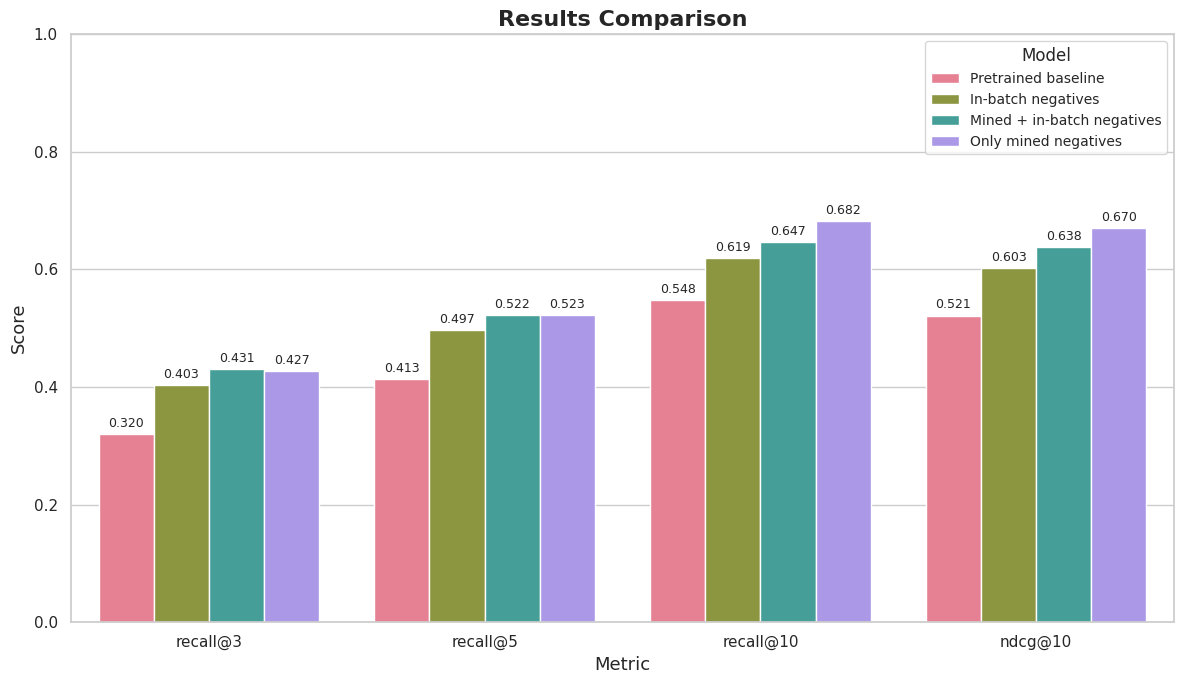

In [ ]:
visualize_metrics(
    [baseline_results, results_random, results_mined, results_custom],
    ["Pretrained baseline", "In-batch negatives", "Mined + in-batch negatives", "Only mined negatives"]
)

Our experiments demonstrate three key insights about fine-tuning embedding models with synthetic data for specialized domains:

1. **Synthetic data is effective**: Even our simplest approach using original query-generation passages as positives with in-batch negatives significantly improved retrieval performance over the baseline.

2. **Mining improves results**: Our second approach, which uses mined positives and negatives while retaining in-batch negatives, showed further improvements in all metrics compared to the basic approach.

3. **Eliminating false negatives helps**: Our third approach, using only carefully mined positives and negatives without in-batch negatives, yielded the best performance. Random in-batch negatives can sometimes include passages that are actually relevant to a query, creating contradictory training signals that can hurt model optimization.

## Conclusion

In this workshop, we've explored the complete pipeline for adapting embedding models to specialized domains using synthetic data:

1. We began with **embedding basics, metrics and models** to understand the foundations of retrieval systems
2. We then explored **synthetic query generation** techniques, progressing from basic approaches to more sophisticated methods using personas, few-shot examples and quality filtering
3. We learned how to **mine positives and negatives** using LLMs and cross-encoders to create high-quality training data
4. Finally, we **fine-tuned embedding models** using different training strategies and demonstrated significant performance improvements on our EU AI Act corpus

These techniques provide a practical framework for improving domain-specific embedding models with relatively modest computational resources, even when labeled data is scarce.

**What to try next:**
> Interested in fine-tuning rerankers? You can use the very same data we prepared in this workshop to fine-tune a reranker. Check out this [brand-new tutorial](https://huggingface.co/blog/train-reranker) for how to do that in Sentence Transformers. You can then use this reranker on top of your existing embedding model or even to produce soft labels for distilling an even stronger embedding model from it.